In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from nltk.tokenize import word_tokenize , sent_tokenize

In [3]:
df=pd.read_csv('cyberbullying_tweets.csv')

In [4]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
df.shape

(47692, 2)

In [6]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [7]:
df.duplicated().sum()

36

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.rename(columns={'cyberbullying_type':'cb'},inplace=True)

# EDA

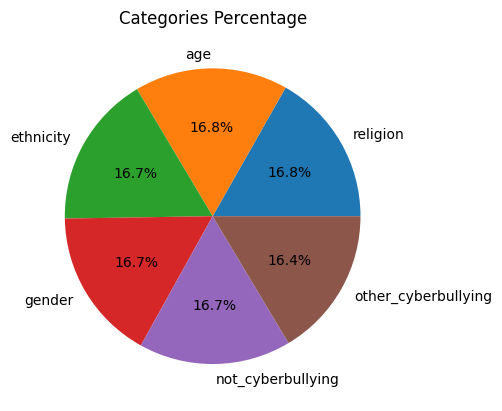

In [10]:
plt.pie(df['cb'].value_counts(),labels=df['cb'].value_counts().index,autopct="%.1f%%")
plt.title('Categories Percentage')
plt.show()

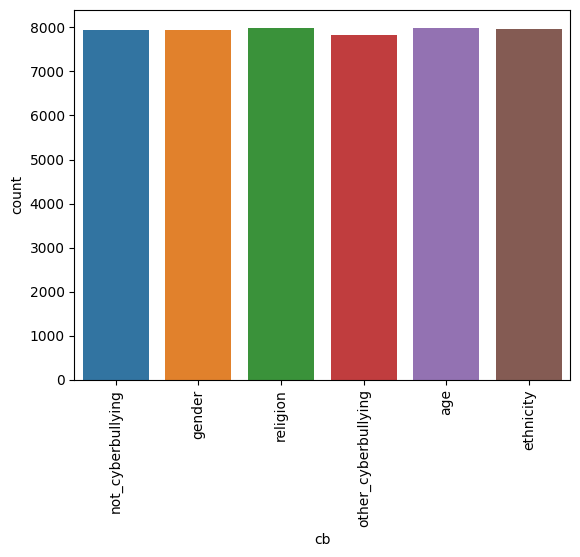

In [11]:
sns.countplot(x='cb', data=df)
plt.xticks(rotation='vertical')  # Rotate x-axis labels vertically
plt.show()

In [12]:
df['cb'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

# Text Preprocessing

In [13]:
stemmer=PorterStemmer()

In [14]:
def preprocess(text):
    text = text.lower()
    text = word_tokenize(text)
    text = [word for word in text if not re.match(r'#\w+', word)]
    translator = str.maketrans('', '', string.punctuation)
    text = [word.translate(translator) for word in text]
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    text=[stemmer.stem(word) for word in text]
    cleaned_text = " ".join(text)
    return cleaned_text


In [15]:
preprocess(df['tweet_text'][0])

'word  katandandr  food crapilici   mkr'

In [16]:
df['clean_text']=df['tweet_text'].apply(preprocess)

### Remaining EDA

In [17]:
from wordcloud import WordCloud

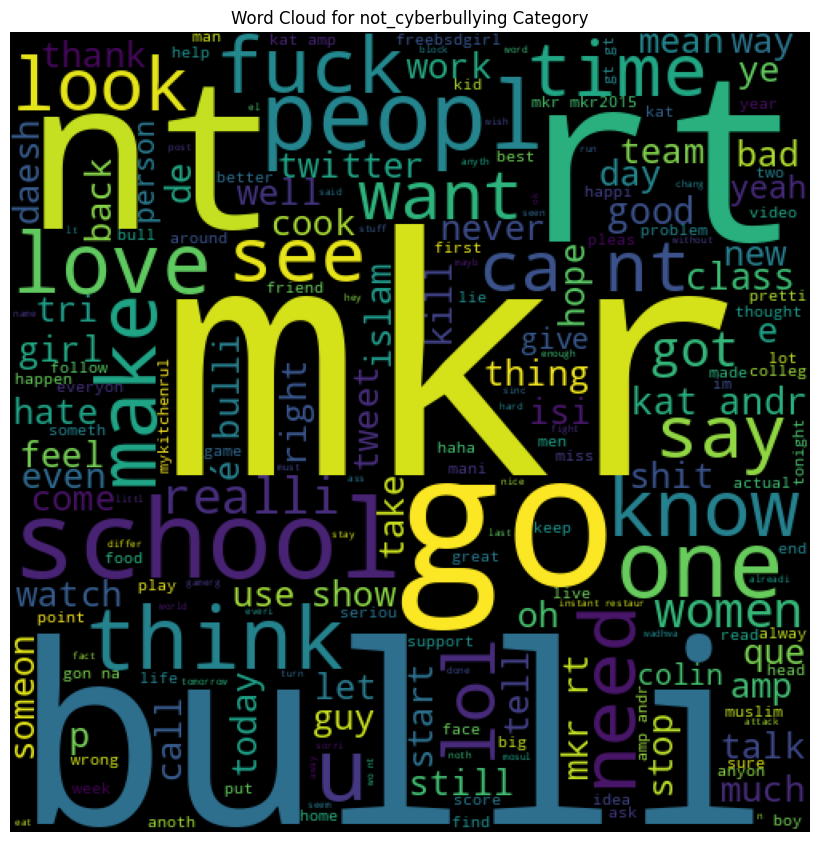

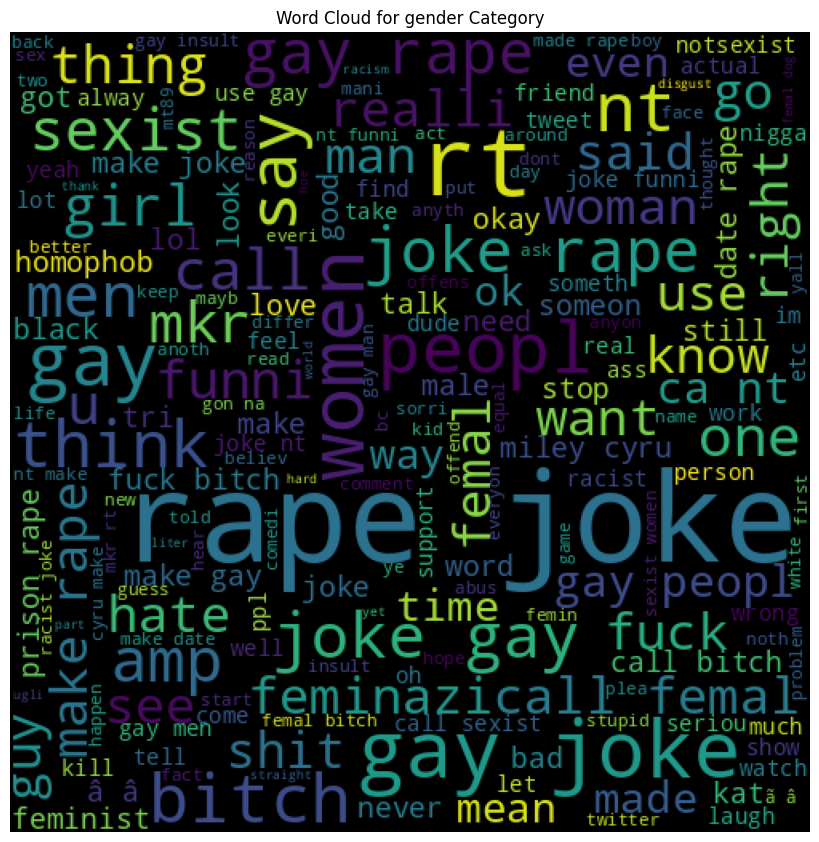

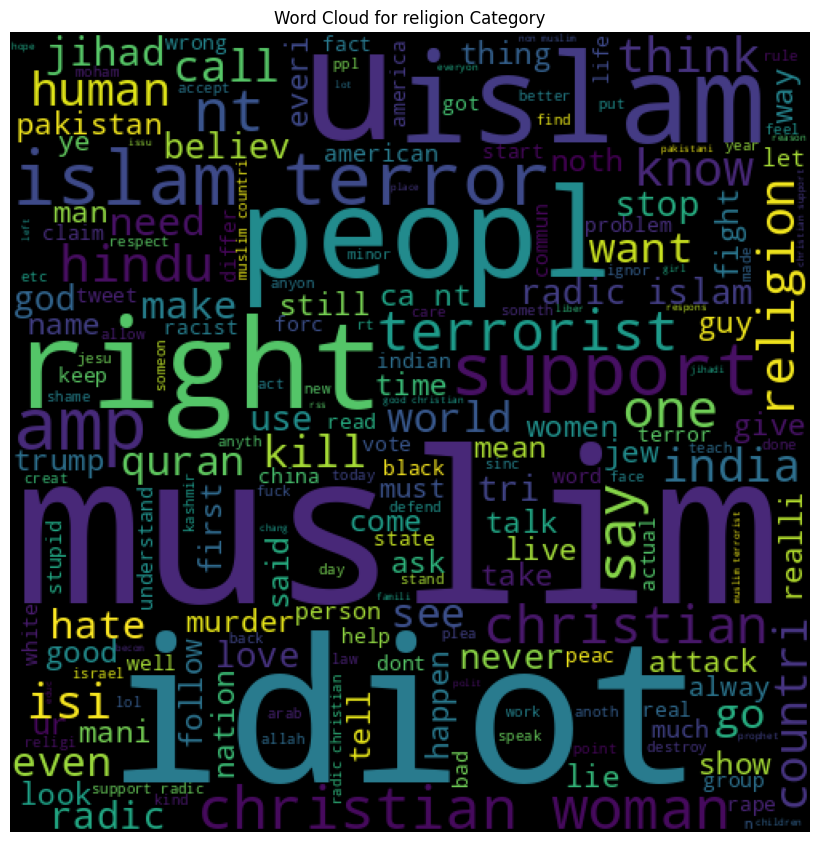

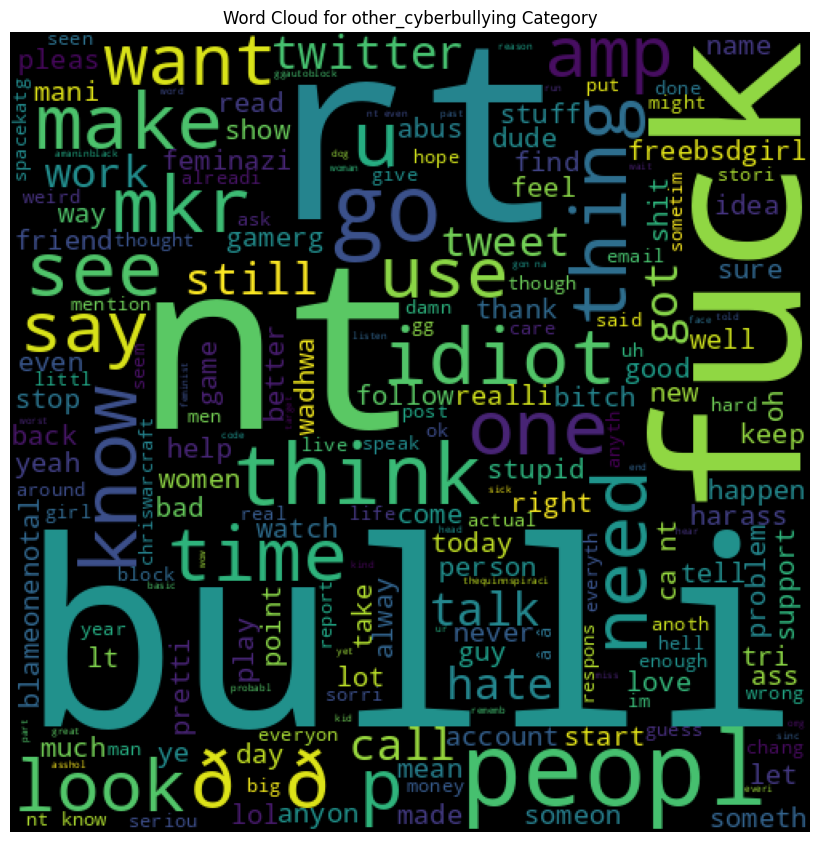

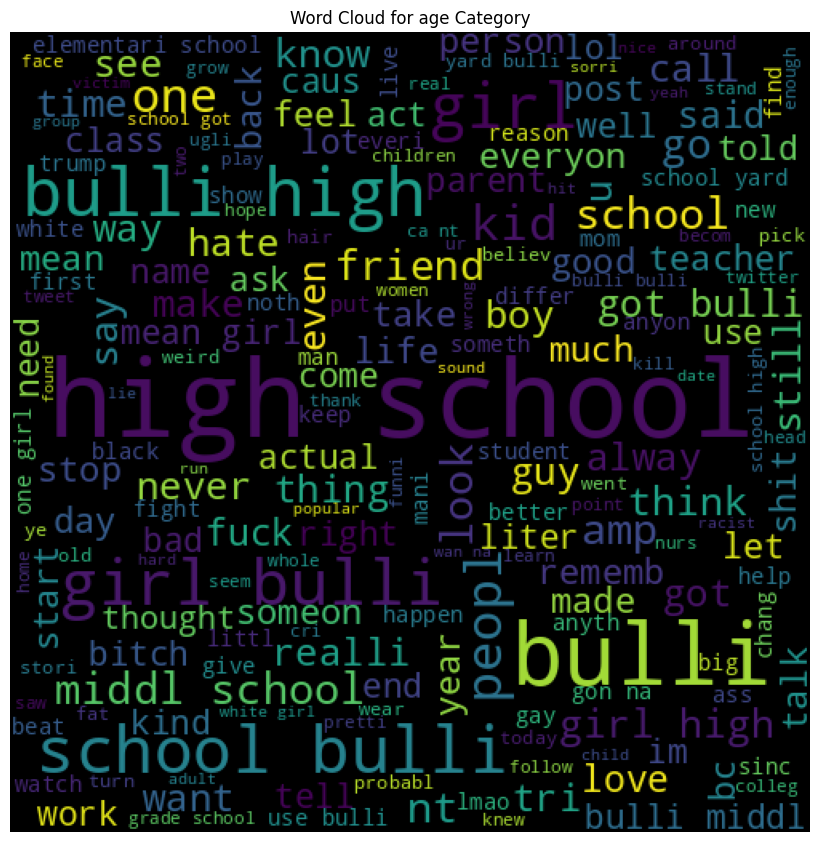

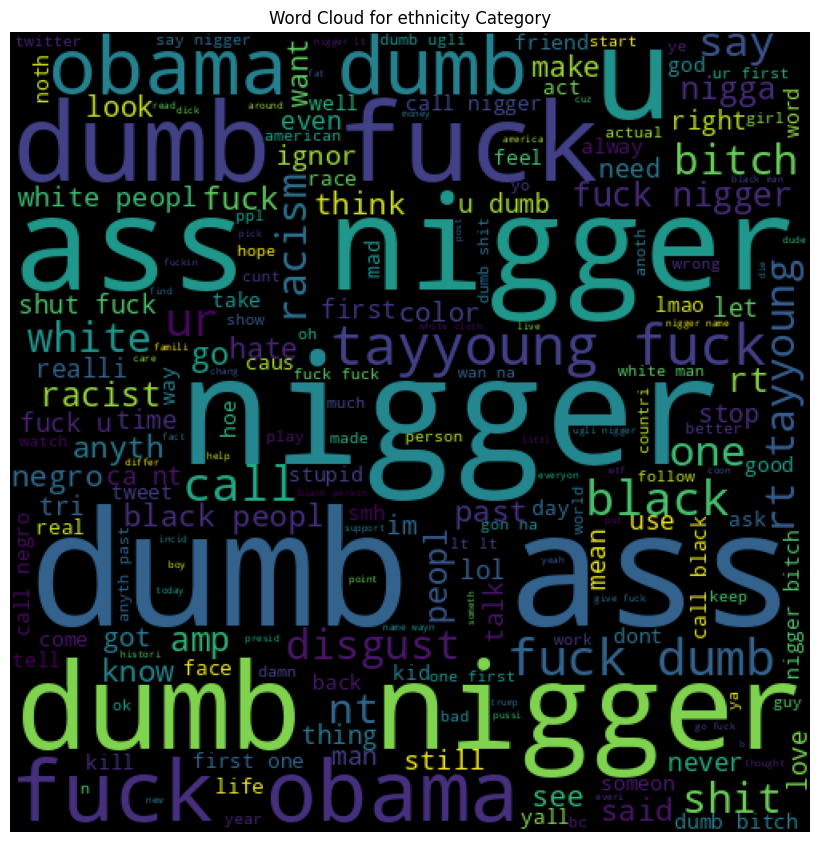

In [18]:
for cat in df['cb'].unique():
    genre_descriptions = ' '.join(df[df['cb'] == cat]['clean_text'])
    wordcloud = WordCloud(width=500, height=500, background_color='black').generate(genre_descriptions)
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title(f'Word Cloud for {cat} Category')
    plt.show()

# Vectorization

In [19]:
for i,value in enumerate(df['cb'].unique()):
  df['cb'].replace({value:i},inplace=True)


In [20]:
from gensim.models import Word2Vec

In [21]:
tokenized_sentences = []
for description in df['tweet_text']:
    sentences = sent_tokenize(description)  # Split description into sentences
    for sentence in sentences:
        words = word_tokenize(sentence.lower())  # Tokenize sentence into words
        tokenized_sentences.append(words)

In [22]:
word_model=Word2Vec(sentences=tokenized_sentences, vector_size=300, window=5, min_count=1, workers=4,epochs=15)

In [23]:
def get_word_embeddings(text, model):
    embeddings = []
    for word in text:
        if word in model.wv:
            embeddings.append(model.wv[word])
    return embeddings

def get_mean_embeddings(text, model, remove_stopwords=True):
    tokens = word_tokenize(text.lower())
    embeddings = get_word_embeddings(tokens, model)
    if embeddings:
        mean_embedding = np.mean(embeddings, axis=0)
    else:
        mean_embedding = np.zeros(model.vector_size)
    return mean_embedding

In [24]:
df['embeddings'] = df['tweet_text'].apply(lambda x: get_mean_embeddings(x, word_model))

In [25]:
df['embeddings'][0].shape

(300,)

In [26]:
import tensorflow as tf
import os
from keras.layers import *

In [27]:
try:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_address) # TPU detection
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  # Going back and forth between TPU and host is expensive.
  # Better to run 128 batches on the TPU before reporting back.
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
  print("Number of accelerators: ", strategy.num_replicas_in_sync)
except ValueError:
  print('TPU failed to initialize.')

Running on TPU  ['10.4.174.226:8470']
Number of accelerators:  8


In [28]:
class Classification(tf.keras.Model):
  def __init__(self):
    super(Classification,self).__init__()
    self.lstm_1=Bidirectional(LSTM(128,activation='relu',return_sequences=True))
    self.lstm_2=Bidirectional(LSTM(64,activation='relu'))
    self.drop=Dropout(0.2)
    self.dense_1=Dense(64,activation='relu')
    self.dense_2=Dense(32,activation='relu')
    self.out=Dense(len(df['cb'].unique()),activation='sigmoid')
  def call(self,inputs):
    x=self.lstm_1(inputs)
    x=self.lstm_2(x)
    x=self.drop(x)
    x=self.dense_1(x)
    x=self.dense_2(x)
    x=self.drop(x)
    x=self.out(x)
    return x

## Converting dataset into tensorflow dataset

In [29]:
x=np.vstack(df['embeddings'].values)
x = x.reshape(-1, 1, 300)
y=df['cb'].values

In [30]:
x

array([[[-0.3524251 , -0.40847635,  0.0986513 , ...,  0.02567128,
         -0.37955645, -0.5613754 ]],

       [[-0.21942182, -0.04272221, -0.5270355 , ...,  0.12138677,
         -0.71276087, -0.8376201 ]],

       [[ 0.0353367 , -0.06830486,  0.18496937, ..., -0.03941414,
         -0.07551467, -0.19889559]],

       ...,

       [[-0.02793306, -0.28786522,  0.25821173, ..., -0.22906674,
         -0.48808   , -0.32206985]],

       [[-0.5585474 , -0.41068366, -0.18372636, ..., -0.00651091,
         -0.88599026, -0.38388273]],

       [[-0.29383063, -0.11044309, -0.236147  , ..., -0.02299251,
         -0.7724521 , -0.0721961 ]]], dtype=float32)

In [31]:
y

array([0, 0, 0, ..., 5, 5, 5])

In [32]:
from sklearn.model_selection import train_test_split

In [33]:
x_train,x_val,y_train,y_val=train_test_split(x,y,random_state=42,train_size=0.8)
x_val,x_test,y_val,y_test=train_test_split(x_val,y_val,random_state=42,test_size=0.1)

In [34]:
train=tf.data.Dataset.from_tensor_slices((x_train, y_train))
val=tf.data.Dataset.from_tensor_slices((x_val,y_val))
test=tf.data.Dataset.from_tensor_slices((x_test,y_test))

In [35]:
len(train)

38124

In [36]:
train

<_TensorSliceDataset element_spec=(TensorSpec(shape=(1, 300), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [37]:
print(len(train),len(val),len(test))

38124 8578 954


In [38]:
batch_size=64

In [59]:
with strategy.scope():
  model=Classification()
  loss=tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  def compute_loss(y_true,y_pred):
    loss_=loss(y_true,y_pred)
    return tf.nn.compute_average_loss( loss_,global_batch_size=batch_size * strategy.num_replicas_in_sync)
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
  optimizer=tf.keras.optimizers.Adam()
  test_loss = tf.keras.metrics.Mean(name='test_loss')
  def training(inputs):
    x,y=inputs
    with tf.GradientTape() as tape:
      pred=model(x)
      loss_=compute_loss(y,pred)
    gradients=tape.gradient(loss_,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    train_accuracy.update_state(y, pred)
    return loss_
  def testing(inputs):
    x,y=inputs
    pred=model(x)
    loss_=loss(y,pred)
    test_loss.update_state(loss_)
    test_accuracy.update_state(y,pred)

  @tf.function
  def distributed_training(dataset):
    loss_per_replica=strategy.run(training,args=(dataset,))
    return strategy.reduce(tf.distribute.ReduceOp.SUM,loss_per_replica,axis=None)
  @tf.function
  def distributed_testing(dataset_inputs):
    strategy.run(testing, args=(dataset_inputs,))

In [60]:
def get_batch(dataset,batch_size=batch_size):
    dataset=dataset.shuffle(1024)
    dataset=dataset.cache()
    dataset=dataset.batch(64,drop_remainder=False)
    dataset = dataset.repeat(1)
    dataset=dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [61]:
def get_dataset(dataset):
  dataset=get_batch(dataset)
  dataset=strategy.experimental_distribute_dataset(dataset)
  return dataset

In [62]:
epochs=20

In [63]:
with strategy.scope():
  for epoch in range(epochs):
    total_loss=0.0

    no_batches=0
    for x in get_dataset(train):
      total_loss+=distributed_training(x)
      no_batches+=1
    train_loss = total_loss / no_batches
    for x in get_dataset(val):
      distributed_testing(x)
    template = ("Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Test Loss: {:.2f}, "
                "Test Accuracy: {:.2f}")
    print (template.format(epoch+1, train_loss,
                           train_accuracy.result()*100, test_loss.result() / strategy.num_replicas_in_sync,
                           test_accuracy.result()*100))
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 1, Loss: 0.09, Accuracy: 71.89, Test Loss: 0.07, Test Accuracy: 79.20


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 2, Loss: 0.06, Accuracy: 79.47, Test Loss: 0.06, Test Accuracy: 80.15


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 3, Loss: 0.06, Accuracy: 80.85, Test Loss: 0.06, Test Accuracy: 81.20


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 4, Loss: 0.06, Accuracy: 81.67, Test Loss: 0.06, Test Accuracy: 80.92


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 5, Loss: 0.05, Accuracy: 82.44, Test Loss: 0.06, Test Accuracy: 81.10


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 6, Loss: 0.05, Accuracy: 82.80, Test Loss: 0.06, Test Accuracy: 81.58


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 7, Loss: 0.05, Accuracy: 83.56, Test Loss: 0.06, Test Accuracy: 81.90


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 8, Loss: 0.05, Accuracy: 84.24, Test Loss: 0.06, Test Accuracy: 81.77


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 9, Loss: 0.05, Accuracy: 84.57, Test Loss: 0.06, Test Accuracy: 81.30


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 10, Loss: 0.04, Accuracy: 85.16, Test Loss: 0.06, Test Accuracy: 81.55


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 11, Loss: 0.04, Accuracy: 85.68, Test Loss: 0.06, Test Accuracy: 82.11


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 12, Loss: 0.04, Accuracy: 86.02, Test Loss: 0.06, Test Accuracy: 81.85


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 13, Loss: 0.04, Accuracy: 86.56, Test Loss: 0.06, Test Accuracy: 81.78


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 14, Loss: 0.04, Accuracy: 87.23, Test Loss: 0.07, Test Accuracy: 81.39


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 15, Loss: 0.04, Accuracy: 87.42, Test Loss: 0.06, Test Accuracy: 81.65


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 16, Loss: 0.04, Accuracy: 87.85, Test Loss: 0.07, Test Accuracy: 80.90


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 17, Loss: 0.03, Accuracy: 88.37, Test Loss: 0.07, Test Accuracy: 81.62


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 18, Loss: 0.03, Accuracy: 88.61, Test Loss: 0.08, Test Accuracy: 81.50


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 19, Loss: 0.03, Accuracy: 89.56, Test Loss: 0.08, Test Accuracy: 80.17


Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence
Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Epoch 20, Loss: 0.03, Accuracy: 89.54, Test Loss: 0.08, Test Accuracy: 80.58


In [67]:
for x in get_dataset(test):
  distributed_testing(x)

Exception ignored in: <function Executor.__del__ at 0x799bad9ff250>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


In [68]:
(test_accuracy.result()*100).numpy()

80.18868